In [1]:
# импорты необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import exp
from sklearn.preprocessing import normalize

In [2]:
# чтение таблицы с нормативами
norms = pd.read_excel('data.xlsx', sheet_name='normatives', index_col='Номер')

In [3]:
# функция преобразования прочитанных значений во float
def to_float(x):
    try:
        x = x.replace(',', '.')
    except:
        pass
    return float(x)

In [4]:
# вычисление и проверка расстояний между границами интервалов
for item in ['Зона опасности', 'Зона риска', 'Зона стабильности']:
    norms[item] = norms[item].apply(to_float)
norms['Dist1'] = norms['Зона опасности'] - norms['Зона риска']
norms['Dist2'] = norms['Зона стабильности'] - norms['Зона опасности']
norms['Check'] = abs(norms['Dist1'] - norms['Dist2']) < 0.01 * abs(norms['Dist1'])
norms['Check'].unique()

array([ True])

Протяженности внутренних интервалов внутри каждого из факторов одинаковы.

In [5]:
# вывод первых 5 строк таблицы факторов для контроля
norms.head(5)

,Группа,Показатель,Отношение,Зона риска,Зона опасности,Зона стабильности,Зона благополучия,Dist1,Dist2,Check
Номер,,,,,,,,,,
1,Показатели оценки структуры баланс,Коэффициент текущей ликвидности,выше,0.8000,0.96000,1.12000,NaN,0.16000,0.16000,True
2,Показатели оценки структуры баланс,Коэффициент обеспеченности собственными средст...,выше,1.6000,1.92000,2.24000,NaN,0.32000,0.32000,True
3,Показатели оценки структуры баланс,Коэффициент соотношения чистых активов и устав...,выше,1.0000,1.20000,1.40000,NaN,0.20000,0.20000,True
4,Показатели рентабельности,Коэффициент рентабельности использования всего...,выше,0.0038,0.00456,0.00532,NaN,0.00076,0.00076,True
5,Показатели рентабельности,Коэффициент использования собственных средств,выше,0.5000,0.60000,0.70000,NaN,0.10000,0.10000,True


In [6]:
# удаление использованных для проверки колонок
norms.drop(columns=['Dist1', 'Dist2', 'Check'], inplace=True)

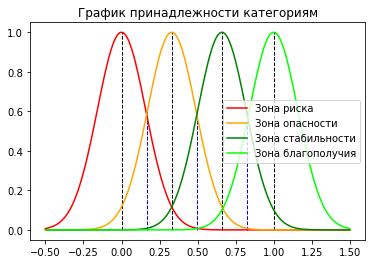

In [7]:
# построение графиков функций принадлежности на эталонном отрезке [0, 1], sigma=0.159
# 4 состояния, стандартные параметры
gauss = np.vectorize(lambda x, c, sigma: exp((-1) * (x - c) * (x - c) / (2 * sigma * sigma)))
sigma = 0.159
x = np.cumsum((np.ones(201) * 0.01)) - 0.51
y1 = gauss(x, 0, sigma)
y2 = gauss(x, 0.33, sigma)
y3 = gauss(x, 0.66, sigma)
y4 = gauss(x, 1, sigma)
plt.plot(x, y1, 'red', x, y2, 'orange', x, y3, 'green', x, y4, 'lime')
for k in [0, 0.33, 0.66, 1]:  # экстремумы функций принадлежности
    plt.vlines(k, 0, 1, color='black', linestyle='dashed', linewidth=1)
for k in [0.165, 0.495, 0.825]:  # пересечения функций принадлежности 
    plt.vlines(k, 0, 0.6, color='blue', linestyle='dashed', linewidth=1)
plt.legend(['Зона риска', 'Зона опасности', 'Зона стабильности', 'Зона благополучия'])
plt.title('График принадлежности категориям')
plt.show()

In [8]:
def belong_f(x, param=1):
    """
    Функция, возвращающая кортеж значений функций принадлежности к каждому из состояний
    """
    # значения, разделяющие интервалы
    splitters = [norms.at[param, 'Зона риска'], norms.at[param, 'Зона опасности'], norms.at[param, 'Зона стабильности']]
    # расчет длины интервала
    interval = np.abs(splitters[1] - splitters[0])  # интервал между границами раздела (из таблицы нормативов)
    k = interval / (0.495 - 0.165)  # коэффициент масштабирования
    # экстремумы функций
    peaks = [splitters[i] - 0.166 * k for i in range(3)] + [splitters[2] + 0.166 * k]
    # расчет сигма для рассматриваемого случая
    sigma = 0.159 * k
    # функция Гаусса
    gauss = lambda x, c, sigma: exp((-1) * (x - c) * (x - c) / (2 * sigma * sigma))
    # значения функции принадлежности к каждой из категорий
    values = np.array([gauss(x, extr, sigma) for extr in peaks])
    # возврат np.array нормированных значений функций принадлежности
    return normalize(values.reshape(1, -1), norm='l1')[0]

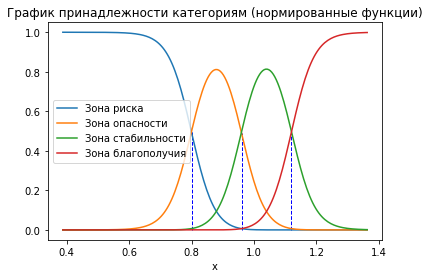

In [9]:
# построение графиков описанной функции принадлежности
# на реальных интервалах переменных
param = 1
splitters = [norms.at[param, 'Зона риска'], norms.at[param, 'Зона опасности'], norms.at[param, 'Зона стабильности']]
interval = np.abs(splitters[1] - splitters[0])  # интервал между границами раздела (из таблицы нормативов)
k = interval / (0.495 - 0.165)  # коэффициент масштабирования
x, values = [], []
for i in range(202):
    current_x = k * i  * 0.01 + k * splitters[0]
    x.append(current_x)
    values.append(belong_f(current_x, param))

b_graph = pd.DataFrame({'x': x, 'y': values})
try:
    score_frame = pd.DataFrame(np.array(b_graph.y.values.tolist()),
                           columns=['y' + str(i) for i in range(1, 5)],
                           index=b_graph.index)
    b_graph = b_graph.join(score_frame)
    b_graph.drop(columns=['y'], inplace=True)
except:
    pass
b_graph.plot.line(x='x', y=['y' + str(i) for i in range(1, 5)])
plt.title('График принадлежности категориям (нормированные функции)')
for n, k in enumerate(splitters):  # пересечения функций принадлежности 
    plt.vlines(k, 0, belong_f(k, param)[n], color='blue', linestyle='dashed', linewidth=1)
plt.legend(['Зона риска', 'Зона опасности', 'Зона стабильности', 'Зона благополучия'])
plt.show()